In [5]:
pip install transformers


In [12]:
!pip install topsis

  Preparing metadata (setup.py) ... done
  Created wheel for topsis: filename=topsis-0.2-py3-none-any.whl size=2161 sha256=bc6f6d3a2429c24ed92e6e56d7b68446419797202b14f1fe38a750d0cae39e0e
  Stored in directory: /root/.cache/pip/wheels/cd/c5/3b/11d030a6ad786089e38f53a98a443815716e7603a0f72999ef
Successfully built topsis


Processing model: GPT-2
Device set to use cpu


Device set to use cpu


Generated text by GPT-2: In the year 2075, humanity had finally achieved interstellar travel. As Captain of the starship Eureka, your mission was to explore the uncharted planet Xylon. Upon landing, you discovered something a...
Processing model: GPT-Neo-125M
Device set to use cpu


Device set to use cpu


Generated text by GPT-Neo-125M: In the year 2075, humanity had finally achieved interstellar travel. As Captain of the starship Eureka, your mission was to explore the uncharted planet Xylon. Upon landing, you discovered something a...
Processing model: BLOOM-560M
Device set to use cpu


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generated text by BLOOM-560M: In the year 2075, humanity had finally achieved interstellar travel. As Captain of the starship Eureka, your mission was to explore the uncharted planet Xylon. Upon landing, you discovered something a...

Final Results:
          Model  Inference Time  Perplexity  Output Quality  TOPSIS Score  \
1  GPT-Neo-125M        5.720248    0.067233            1.80      0.265110   
2    BLOOM-560M        2.009462    0.033020            0.98      1.000000   
0         GPT-2        8.310299    0.047952            1.72      0.290909   

   Rank  
1     1  
2     2  
0     3  


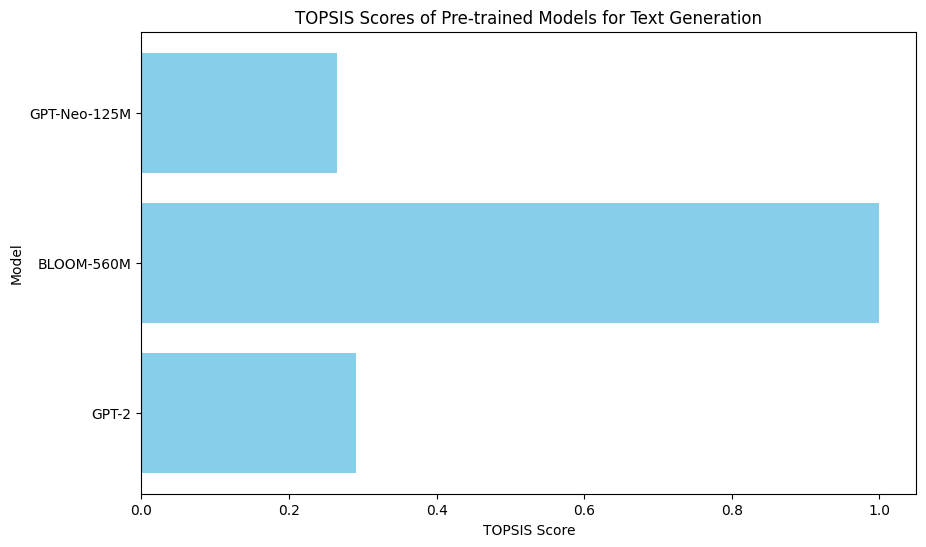

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
models = {
    "GPT-2": "gpt2",
    "GPT-Neo-125M": "EleutherAI/gpt-neo-125M",
    "BLOOM-560M": "bigscience/bloom-560m"
}

prompt = (
    "In the year 2075, humanity had finally achieved interstellar travel. As Captain of the starship Eureka, "
    "your mission was to explore the uncharted planet Xylon. Upon landing, you discovered something astonishing—"
    "an ancient structure glowing with an otherworldly light. As you step closer, the structure begins to hum, and suddenly..."
)

results = []
def calculate_perplexity(log_probs):
    return math.exp(-sum(log_probs) / len(log_probs))

for model_name, model_path in models.items():
    print(f"Processing model: {model_name}")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device set to use {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if device == "cuda" else -1)

    import time
    start_time = time.time()
    output = generator(
        prompt,
        max_new_tokens=50,
        num_return_sequences=1,
        truncation=True,
        pad_token_id=tokenizer.eos_token_id
    )
    inference_time = time.time() - start_time

    generated_text = output[0]["generated_text"]
    tokens = tokenizer.encode(generated_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(tokens, labels=tokens)
        log_probs = outputs.loss.item()
        perplexity = calculate_perplexity([log_probs])

    print(f"Generated text by {model_name}: {generated_text[:200]}...")

    output_quality = len(generated_text.split()) / 50

    results.append({
        "Model": model_name,
        "Inference Time": inference_time,
        "Perplexity": perplexity,
        "Output Quality": output_quality
    })

df = pd.DataFrame(results)

def topsis(matrix, weights, impacts):
    normalized_matrix = matrix / np.sqrt((matrix ** 2).sum(axis=0))
    weighted_matrix = normalized_matrix * weights
    ideal_best = np.max(weighted_matrix, axis=0) if impacts[0] == '+' else np.min(weighted_matrix, axis=0)
    ideal_worst = np.min(weighted_matrix, axis=0) if impacts[0] == '+' else np.max(weighted_matrix, axis=0)
    separation_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
    separation_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))
    topsis_scores = separation_worst / (separation_best + separation_worst)
    ranks = topsis_scores.argsort()[::-1] + 1
    return topsis_scores, ranks

decision_matrix = df[["Inference Time", "Perplexity", "Output Quality"]].values
weights = [0.3, 0.4, 0.3]
impacts = ["-", "-", "+"]
df["TOPSIS Score"], df["Rank"] = topsis(decision_matrix, weights, impacts)

df = df.sort_values(by="Rank")

print("\nFinal Results:")
print(df)

plt.figure(figsize=(10, 6))
plt.barh(df["Model"], df["TOPSIS Score"], color='skyblue')
plt.xlabel("TOPSIS Score")
plt.ylabel("Model")
plt.title("TOPSIS Scores of Pre-trained Models for Text Generation")
plt.gca().invert_yaxis()
plt.show()
